## import

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import cv2

import tensorflow as tf
import tflearn
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d

%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Manager Class

In [2]:
class DataManager():
    
    def __init__(self):
        self.N = 256
        self.dif = 128
        self.window = np.hamming(self.N)
        self.im_width = 128
        
    def voice2images(self, data, folder_name = "images"):
        i = 0
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        while(True):
            _data = data[i*_dif:i*_dif + _wav]
            if (len(_data) < _wav):
                break
            self.save_image(self.spec2image(_data), folder_name + "/" + str(i) + ".png")
            i = i + 1
    
    def images2voice(self, image_num = 10000, folder_name = "images"):
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        voice = np.zeros(_dif * (image_num+1))
        for i in range(image_num):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            if data is None:
                break
            voice[i*_dif:i*_dif+_wav] = voice[i*_dif:i*_dif+_wav] + self.image2spec(data)*np.r_[np.linspace(0,1,_dif), np.linspace(1,0,_dif)]
        
        """
        voice = []
        for i in range(image_num):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            voice.append(self.image2spec(data))
        """
        return voice
        
    def spec2image(self, data):
        image = []
        for i in range(self.im_width):
            image.append(self.dct(data[self.dif*i:self.dif*i + self.N]))
        return image
    
    def image2spec(self, data):
        voice = np.zeros(self.N + self.dif*(self.im_width-1))        
        vsum = np.zeros(self.N + self.dif*(self.im_width-1))
        for i in range(self.im_width):
            voice[self.dif*i:self.dif*i + self.N] = voice[self.dif*i:self.dif*i + self.N] + self.idct(data[i]) * self.window
            vsum[self.dif*i:self.dif*i + self.N] +=self.window ** 2 
        pos = (vsum != 0)
        voice[pos] /= vsum[pos]
        return voice
        
    def dct(self, data):       
        data = data * self.window
        data = scipy.fftpack.dct(data)
        pm = np.sign(data)
        data = np.log(np.abs(data)+0.0001)
        data = pm * data
        data = data[:int(self.N/2)]
        data = data / 20
        return data
    
    def idct(self, data):
        data = data * 20
        pm = np.sign(data)
        data = np.exp(np.abs(data))
        data = pm * data
        data = np.append(data, np.zeros(int(self.N/2)))
        data = scipy.fftpack.idct(data) / (2 * len(data))
        return data

    def read_wave(self, filename):
        wf = wave.open(filename , "r" )
        buf = wf.readframes(wf.getnframes())
        data = np.frombuffer(buf, dtype="int16") # 16 kHz?
        return data    
    
    def save_wave(self, data, filename):
        wf = wave.open(filename, "w")
        wf.setnchannels(2)
        wf.setsampwidth(2) #2 byte = 16 bit
        wf.setframerate(16000)
        wf.writeframes(np.array(data,  dtype="int16"))
        wf.close()
        
    def save_image(self, data, file_name):
        data = np.array(data) * 255
        cv2.imwrite(file_name, data)
        
    def read_image(self, file_name):
        data = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        return data / 255

## Data init

In [11]:
dm = DataManager()

In [12]:
voice1 = dm.read_wave("VoiceData/kamiya.wav")
dm.voice2images(voice1, "ImageData/Kamiya_images")

voice2 = dm.read_wave("VoiceData/kizuna.wav")
dm.voice2images(voice2, "ImageData/Kizuna_images")

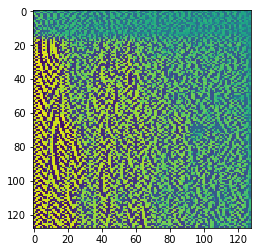

In [13]:
image = dm.spec2image(voice1)
plt.imshow(image)

In [14]:
re_voice = dm.image2spec(image)
voice = dm.images2voice(2000, "ImageData/Kamiya_images")
dm.save_wave(voice, "test.wav")

## Network

In [2]:
class DiscoGAN():
    
    def __init__(self, sess):
        
        self.sess = sess
                    
        self.x_1 = tflearn.input_data(shape=[None, 128, 128, 1])
        self.x_2 = tflearn.input_data(shape=[None, 128, 128, 1])
        
        self.gen_learning_rate = 0.01
        self.dis_learning_rate = 0.01
        
        self.param_gan = 0.1
        self.param_feat = 0.9
        self.param_recon = 1.
        
        self._create_optimizer()
        
        sess.run(tf.global_variables_initializer())
    
    def create_gen_network(self, network_name, inputs, reuse=None):
        with tf.variable_scope(network_name, reuse=reuse):
            
            network = conv_2d(inputs, 64, 1,  activation='relu')
            #network = batch_normalization(network)
            network = conv_2d(network, 128, 1, activation='relu')
            #network = batch_normalization(network)
            network = conv_2d(network, 256, 1, activation='relu')
            #network = batch_normalization(network)
            network = conv_2d(network, 512, 1, activation='relu')
            
            network = conv_2d(network, 512, 1,  activation='relu')
            #network = batch_normalization(network)
            network = conv_2d(network, 128, 1,  activation='relu')
            #network = batch_normalization(network)
            network = conv_2d(network, 64, 1,  activation='relu')
            #network = batch_normalization(network)
            outputs = conv_2d(network, 1, 1,  activation='relu')
            
        return outputs
        
    def create_dis_network(self, network_name, inputs, reuse=None):
        with tf.variable_scope(network_name, reuse=reuse):
            
            network = conv_2d(inputs, 64, 1,  activation='relu')
            network = conv_2d(network, 128, 1, activation='relu')
            network = conv_2d(network, 256, 1, activation='relu')
            network = conv_2d(network, 512, 1, activation='relu')
            network = fully_connected(network, 256, activation='relu')
            outputs = fully_connected(network, 2, activation='sigmoid')
            
        return outputs, network
    
    def _create_optimizer(self):

        x_12 = self.create_gen_network("G1", self.x_1)
        x_21 = self.create_gen_network("G2", self.x_2)

        x_121 = self.create_gen_network("G2", x_12, reuse=True)
        x_212 = self.create_gen_network("G1", x_21, reuse=True)

        recon_loss_1 = tf.losses.mean_squared_error(self.x_1, x_121)
        recon_loss_2 = tf.losses.mean_squared_error(self.x_2, x_212)

        y_1_real, feats_1_real = self.create_dis_network("D1", self.x_1)
        y_1_fake, feats_1_fake = self.create_dis_network("D1", x_21, reuse=True)

        y_2_real, feats_2_real = self.create_dis_network("D2", self.x_2)
        y_2_fake, feats_2_fake = self.create_dis_network("D2", x_12, reuse=True)

        """
        feat_loss_1 = self.compute_loss_feat(feats_a_real, feats_a_fake)

        gan_loss_dis_2, gan_loss_gen_2 = self.compute_loss_gan(y_b_real, y_b_fake)
        feat_loss_2 = self.compute_loss_feat(feats_b_real, feats_b_fake)

        # gan = 0.1
        # feat = 0.9
        # recon = 1

        gan_loss_dis_1, gan_loss_gen_1 = self.compute_loss_gan(y_a_real, y_a_fake)


        total_loss_gen_1 = self.gan*gan_loss_gen_2 + self.feat*feat_loss_2 + self.recon*recon_loss_1
        total_loss_gen_2 = self.gan*gan_loss_gen_1 + self.feat*feat_loss_1 + self.recon*recon_loss_2

        self.gen_loss = total_loss_gen_a + total_loss_gen_b
        self.dis_loss = gan_loss_dis_a + gan_loss_dis_b
        """
        
        self.gen_loss = recon_loss_1
        self.dis_loss = recon_loss_2
        
        self.gen_optimize = tf.train.AdamOptimizer(self.dis_learning_rate).minimize(
            loss=self.gen_loss
        )
        self.dis_optimize = tf.train.AdamOptimizer(self.gen_learning_rate).minimize(
            loss=self.dis_loss
        )
        
    def train(self, x_1, x_2):
        self.sess.run(self.gen_optimize, feed_dict={
            self.x_1: x1,
            self.x_2: x2
        })        


In [3]:
def main():
    with tf.Session() as sess:
        
        discoGAN = DiscoGAN(sess)
        
        image = dm.read_image("ImageData/Kamiya_images/1.png")
        for i in range(10):
            print(i)
            discoGAN.train(image, image)

In [2]:
main()

NameError: name 'main' is not defined